## Intro

In [ ]:
from pymbd import MBDCalc, from_volumes, ang, vdw_params, get_kgrid

from mbdvv.app import app, kcal, ev
from mbdvv.utils import last, listify, chunks
from mbdvv.physics import reduced_grad, vv_pol, calc_vvpol, rgrad_cutoff, bin_alpha_vv

from scipy.special import erf
import numpy as np
import pandas as pd
from math import ceil
import os
from collections import OrderedDict
from itertools import product, islice
from functools import partial
from pkg_resources import resource_stream
from tqdm import tqdm
import re
pd.options.display.max_rows = 999

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='ticks', rc={
    'axes.formatter.useoffset': False,
})
%config InlineBackend.figure_format = 'svg'

### Common functions

In [ ]:
def savefig(fig, name, ext='pdf', **kwargs):
    fig.savefig(f'../media/{name}.{ext}', transparent=True, bbox_inches='tight', **kwargs)
    
def ene_int(x, ds):
    key = x.iloc[0].name[:2]
    enes = x.reset_index('scale label'.split(), drop=True).ene.unstack('fragment')
    cluster = ds.clusters[key]
    try:
        enes_int = cluster.get_int_ene(enes)
    except KeyError:
        return np.nan*enes.iloc(1)[0]
    return enes_int

def ref_delta(x, ds):
    ref = ds.df.loc(0)[x.name[:2]].energy
    if ds.name == 'S66' and ref > 0:
        ref = np.nan
    ene = x.ene.reset_index('scale label'.split(), drop=True)
    delta = ene-ref
    reldelta = delta/abs(ref)
    return pd.DataFrame(OrderedDict({
        'ene': ene,
        'delta': ene-ref,
        'reldelta': (ene-ref)/abs(ref),
    }))

def ene_dft_vdw(x):
    ipbe = x.index == 'PBE'
    x = x.where(ipbe, lambda y: y + x['PBE'])
    x.index = x.index.where(ipbe, 'PBE+' + x.index)
    return x
    
def ds_stat(x):
    return pd.Series(OrderedDict({
        'N': len(x.dropna()),
        'MRE': x['reldelta'].mean(),
        'MARE': abs(x['reldelta']).mean(),
        'MdRE': x['reldelta'].median(),
        'MdARE': abs(x['reldelta']).median(),
        'SDRE': abs(x['reldelta']).std(),
        'ME': x['delta'].mean(),
        'MAE': abs(x['delta']).mean(),
    }))

def splice_key(df, indexes):
    return df.reset_index().assign(
        label=lambda x: x.key.map(lambda y: y[0]),
        scale=lambda x: x.key.map(lambda y: y[1]),
    ).drop('key', 1).set_index(['label', 'scale', *indexes])

def get_nk(lattice, density):
    rec_lattice = 2*np.pi*np.linalg.inv(lattice.T)
    rec_lens = np.sqrt((rec_lattice**2).sum(1))
    nkpts = np.ceil(rec_lens/(density/ang**2))
    return int(nkpts[0]), int(nkpts[1]), int(nkpts[2])

### MBD functions

In [ ]:
class MBDException(Exception):
    pass


class NegativeEigs(MBDException):
    pass


class NegativeAlpha(MBDException):
    pass


def scaled_eigs(x):
    return np.where(x >= 0, x, -erf(np.sqrt(np.pi)/2*x**4)**(1/4))


def mbd_rsscs(mbd_calc, coords, alpha_0, C6, R_vdw, beta, lattice=None,
              k_grid=None, rpa=False, scs=False, scale_eigs=True, fortran=False,
              ts=False, ord2=False, damping='fermi,dip', param_a=6.):
    def _array(obj, *args, **kwargs):
        if obj is not None:
            return np.array(obj, *args, **kwargs)

    if fortran:
        return mbd_calc.mbd_energy(coords, alpha_0, C6, R_vdw, beta, lattice, k_grid)
    coords = _array(coords, dtype=float, order='F')
    alpha_0 = _array(alpha_0, dtype=float)
    C6 = _array(C6, dtype=float)
    R_vdw = _array(R_vdw, dtype=float)
    freq, freq_w = mbd_calc.omega_grid
    omega = 4./3*C6/alpha_0**2
    if not scs:
        alpha_0_rsscs = alpha_0
        C6_rsscs = C6
        R_vdw_rsscs = R_vdw
        omega_rsscs = omega
    else:
        alpha_dyn = alpha_0/(1+(freq[:, None]/omega)**2)
        alpha_dyn_rsscs = np.empty_like(alpha_dyn)
        for a, a_scr in zip(alpha_dyn, alpha_dyn_rsscs):
            sigma = (np.sqrt(2./np.pi)*a/3)**(1./3)
            a_nlc = np.linalg.inv(
                np.diag(np.repeat(1./a, 3)) + mbd_calc.dipole_matrix(
                    coords, damping + ',gg', sigma=sigma, R_vdw=R_vdw,
                    beta=beta, lattice=lattice,
                )
            )
            a_scr[:] = np.array([a_nlc[i::3, i::3].sum(1) for i in range(3)]).sum(0)/3
        alpha_0_rsscs = alpha_dyn_rsscs[0, :]
        if np.any(alpha_0_rsscs <= 0):
            raise NegativeAlpha(alpha_0_rsscs)
        C6_rsscs = 3./np.pi*np.sum(freq_w[:, None]*alpha_dyn_rsscs**2, 0)
        R_vdw_rsscs = R_vdw*(alpha_0_rsscs/alpha_0)**(1./3)
        omega_rsscs = 4./3*C6_rsscs/alpha_0_rsscs**2
    if ts:
        return mbd_calc.ts_energy(coords, alpha_0_rsscs, C6_rsscs, R_vdw_rsscs, beta, lattice)
    pre = np.repeat(omega_rsscs*np.sqrt(alpha_0_rsscs), 3)
    if lattice is None:
        k_grid = [None]
    else:
        assert k_grid is not None
        k_grid = get_kgrid(lattice, k_grid)
    ene = 0
    for k_point in k_grid:
        T = mbd_calc.dipole_matrix(
            coords, damping, R_vdw=R_vdw_rsscs, beta=beta, a=param_a,
            lattice=lattice, k_point=k_point
        )
        if rpa:
            for u, uw in zip(freq[1:], freq_w[1:]):
                A = np.diag(np.repeat(alpha_0_rsscs/(1+(u/omega_rsscs)**2), 3))
                eigs = np.linalg.eigvals(A@T)
                eigs = np.real(eigs)
                if scale_eigs:
                    eigs = scaled_eigs(eigs)
                if np.any(eigs <= -1):
                    raise NegativeEigs(k_point, u, eigs)
                if ord2:
                    log_eigs = -eigs**2/2
                elif not scale_eigs:
                    log_eigs = np.log(1+eigs)
                else:
                    log_eigs = np.log(1+eigs)-eigs
                ene += 1/(2*np.pi)*np.sum(log_eigs)*uw
        else:
            eigs = np.linalg.eigvalsh(
                np.diag(np.repeat(omega_rsscs**2, 3))+np.outer(pre, pre)*T
            )
            if np.any(eigs < 0):
                raise NegativeEigs(k_point, eigs)
            ene += np.sum(np.sqrt(eigs))/2-3*np.sum(omega_rsscs)/2
    ene /= len(k_grid)
    return ene

### Polarizabilities

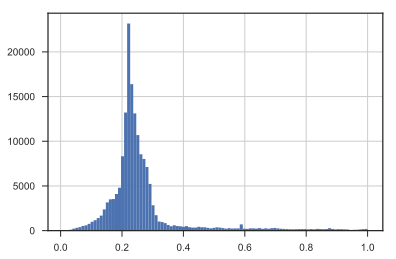

In [ ]:
with app.context():
    _fname = app.get('s66')[0].loc(0)['Benzene ... AcOH', 1.0, 'fragment-1'].gridfile
    
pd.read_hdf(_fname).loc[lambda x: x.rho > 0].pipe(reduced_grad).loc[lambda x: x < 1].hist(bins=100); 

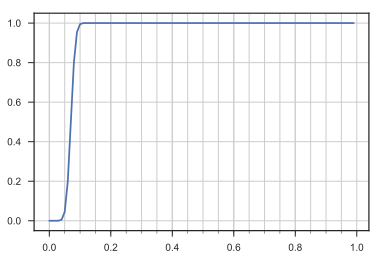

In [ ]:
_fig, _ax = plt.subplots()
_x = np.arange(0, 1, 0.01)
_ax.plot(_x, rgrad_cutoff(_x));
_ax.grid(which='both')
_ax.set_xticks(np.arange(0, 1, 0.05), minor=True);

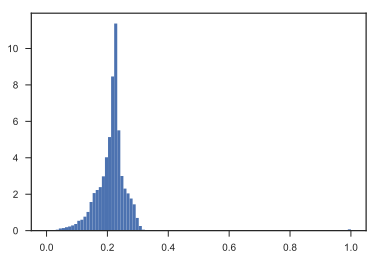

In [ ]:
def plot_binned(ax, bins, y):
    return ax.bar((bins[1:]+bins[:-1])/2, y, bins[1]-bins[0])

_bins = np.linspace(0, 1, 100)
_subsums = bin_alpha_vv(pd.read_hdf(_fname), _bins)
_fig, _ax = plt.subplots()
plot_binned(_ax, _bins, _subsums.vv_pol);

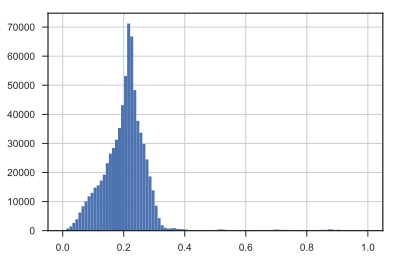

In [ ]:
with app.context():
    _fname = app.get('x23')[0] .loc(0)['Benzene', 1.0, 'crystal'].gridfile
    
pd.read_hdf(_fname).loc[lambda x: x.rho > 0].pipe(reduced_grad).loc[lambda x: x < 1].hist(bins=100); 

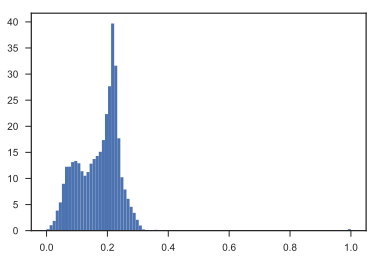

In [ ]:
_bins = np.linspace(0, 1, 100)
_subsums = bin_alpha_vv(pd.read_hdf(_fname), _bins)
_fig, _ax = plt.subplots()
plot_binned(_ax, _bins, _subsums.vv_pol);

In [ ]:
with app.context():
    _df, _ds = app.get('solids')
_df = _df['solids']

In [ ]:
solids_pts = pd.concat(
    dict(_df.gridfile.loc[:, 1., 'crystal'].apply(lambda x: pd.read_hdf(x))),
    names=('label', 'i_point')
)['i_atom part_weight rho rho_grad_norm'.split()]

In [ ]:
def add_group(x, ds):
    return x.assign(group=ds.df.loc(0)[x.name, 1.].group)

(
    solids_pts
    .set_index('i_atom', append=True)
    .pipe(calc_vvpol, 0, rgrad_cutoff).stack().reset_index(-1, drop=True)
    .groupby('label i_atom'.split()).sum()
    .groupby('label').apply(add_group, _ds).set_index('group', append=True)
    .to_csv('../results/solids-vv-atom-pols.csv')
)

In [ ]:
(
    pd.read_csv('../results/solids-vv-atom-pols.csv', index_col='label i_atom group'.split())
    .pipe(lambda x: x.vvpol_nm/x.vvpol)
    .groupby('group').describe()
)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
IC,12.0,0.815044,0.101572,0.660033,0.708255,0.840347,0.904903,0.945546
MM,9.0,0.247724,0.178411,0.059691,0.128305,0.210140,0.254122,0.662642
SC,48.0,0.939766,0.015877,0.898201,0.931267,0.936857,0.951531,0.972435
TM,14.0,0.602681,0.116345,0.424385,0.505016,0.593333,0.707985,0.763674
TMCN,20.0,0.845761,0.049296,0.773772,0.799341,0.859913,0.883372,0.913482


In [ ]:
_bins = np.linspace(0, 1, 50)
_subsums = bin_alpha_vv(solids_pts.reset_index('i_point'), _bins)
_subsums.to_csv('../results/solids-subsums.csv')

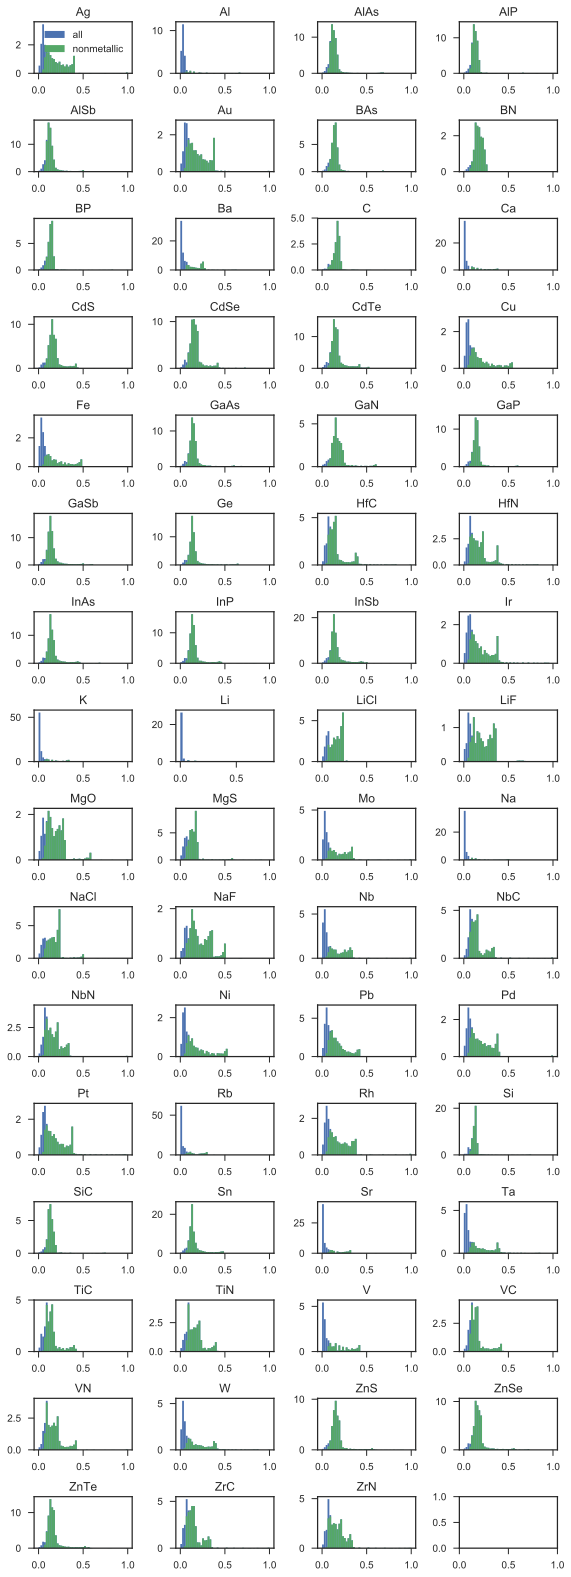

In [ ]:
def plot_hist_solids(axes, bins, subsums):
    binmids = (bins[1:]+bins[:-1])/2 
    width = bins[1]-bins[0]
    for ax, (label, df) in zip((ax for ax_row in axes for ax in ax_row), subsums.groupby('label')):
        rgrad = binmids[df.index.get_level_values('binidx')-1]
        ax.bar(rgrad, df.vv_pol, width, label='all')
        ax.bar(rgrad, df.vv_pol_nm, width, label='nonmetallic')
        ax.set_title(label)
        if label == 'Ag':
            ax.legend()
    
    
_subsums = pd.read_csv('../results/solids-subsums.csv', index_col='label binidx'.split())
_fig, _axes = plt.subplots(ceil(len(_subsums.index.levels[0])/4), 4, figsize=(8, 22))
plot_hist_solids(_axes, _bins, _subsums)
_fig.tight_layout()
savefig(_fig, 'alpha-rgrad-hists')

In [ ]:
def get_atomic_quants():
    with app.context():
        dfs_dft, ds = app.get('solids')
    with MBDCalc(4) as mbd_calc:
        freq, freq_w = mbd_calc.omega_grid
        alpha_vv = (
            solids_pts
            .set_index('i_atom', append=True)
            .pipe(calc_vvpol, freq, rgrad_cutoff)
            .groupby('label i_atom'.split()).sum()
        )
    df = []
    for (*key, fragment), data, _ in dfs_dft['solids'].loc(0)[:, 1.].itertuples():
        if fragment != 'crystal':
            continue
        species = listify(data['elems']['atom'])
        free_atoms = last(data['free_atoms'])
        species_idx = free_atoms['species']-1
        volume_ratios = last(data['volumes'])/free_atoms['volumes'][species_idx]
        alpha_0_free, C6_free, R_vdw_free = from_volumes(species, 1, kind='TS')
        alpha_vv_free = free_atoms['vv_pols'][:, species_idx]
        alpha_0_vv = last(data['vv_pols']).copy()[0]
        C6_vv_free = 3/np.pi*np.sum(last(data['omega_grid_w'])[:, None]*alpha_vv_free**2, 0)
        df.append(pd.DataFrame(OrderedDict({
            'label': key[0],
            'i_atom': list(range(1, len(species_idx)+1)),
            'species': species,
            'hirsh_ratios': volume_ratios,
            'alpha_0_free': alpha_0_free,
            'alpha_0_vvfree': alpha_vv_free[0],
            'alpha_0_hirsh': alpha_0_free*volume_ratios,
            'alpha_0_vv': alpha_0_vv,
            'alpha_0_vv2': alpha_vv.loc(0)[key[0]].vvpol.values.T[0],
            'alpha_0_vv_nm': alpha_vv.loc(0)[key[0]].vvpol_nm.values.T[0],
            'alpha_0_vvcorr': alpha_0_vv*alpha_0_free/alpha_vv_free[0],
            'alpha_0_vv_nmcorr': alpha_vv.loc(0)[key[0]].vvpol_nm.values.T[0]*alpha_0_free/alpha_vv_free[0],
            'C6_free': C6_free,
            'C6_hirsh': C6_free*volume_ratios**2,
            'C6_vvfree': 3/np.pi*np.sum(last(data['omega_grid_w'])[:, None]*alpha_vv_free**2, 0),
            'C6_vv': 3/np.pi*np.sum(freq_w[:, None]*alpha_vv.loc(0)[key[0]].vvpol.values.T**2, 0),
            'C6_vv_nm': 3/np.pi*np.sum(freq_w[:, None]*alpha_vv.loc(0)[key[0]].vvpol_nm.values.T**2, 0),
            'C6_vvcorr': 3/np.pi*np.sum(freq_w[:, None]*alpha_vv.loc(0)[key[0]].vvpol.values.T**2, 0)*C6_free/C6_vv_free,
            'C6_vv_nmcorr': 3/np.pi*np.sum(freq_w[:, None]*alpha_vv.loc(0)[key[0]].vvpol_nm.values.T**2, 0)*C6_free/C6_vv_free,
            'Rvdw_free': R_vdw_free,
            'Rvdw_17_free': 2.5*alpha_0_free**(1/7),
            'Rvdw_hirsh': R_vdw_free*volume_ratios**(1/3),
            'Rvdw_hirsh_17base': (2.5*alpha_0_free**(1/7))*volume_ratios**(1/3),
            'Rvdw_vv17': 2.5*alpha_0_vv**(1/7),
            'Rvdw_vvcorr17': 2.5*(alpha_0_vv*alpha_0_free/alpha_vv_free[0])**(1/7),
        })))
    return (
        pd
        .concat(df).set_index('label i_atom'.split())
        .assign(group=lambda x: ds.df.loc(0)[[(lbl, 1.) for lbl in x.index.get_level_values('label')]].group.values)
        .groupby('group').apply(lambda x: x.sort_index())
    )
        
_df = get_atomic_quants().round(2)
_df.to_csv('../results/solids-vdw-params.csv')

In [ ]:
def get_atomic_quants():
    with app.context():
        df_dft, ds, alpha_vv = app.get('s66')
        alpha_vv = pd.read_hdf(alpha_vv['alpha.h5'].path)
    df = []
    for (*key, fragment), data, _ in df_dft.loc(0)[:, 1.].itertuples():
        if fragment != 'complex':
            continue
        df_alpha_vv = alpha_vv.loc(0)[(*key, fragment)]
        species = listify(data['elems']['atom'])
        free_atoms = last(data['free_atoms'])
        species_idx = free_atoms['species']-1
        volume_ratios = last(data['volumes'])/free_atoms['volumes'][species_idx]
        alpha_0_free, _, R_vdw_free = from_volumes(species, 1)
        alpha_vv_free = free_atoms['vv_pols'][0, species_idx]
        alpha_0_vv = last(data['vv_pols']).copy()[0]
        df.append(pd.DataFrame(OrderedDict({
            'label': key[0],
            'i_atom': list(range(1, len(species_idx)+1)),
            'species': species,
            'hirsh_ratios': volume_ratios,
            'vv_ratios': alpha_0_vv/alpha_vv_free,
            'alpha_0_free': alpha_0_free,
            'alpha_0_vv_free': alpha_vv_free,
            'alpha_0_hirsh': alpha_0_free*volume_ratios,
            'alpha_0_vv': alpha_0_vv,
            'alpha_0_vv[nm]': df_alpha_vv.vvpol_nm.values.T[0],
            'alpha_0_vvcorr': alpha_0_vv*alpha_0_free/alpha_vv_free,
            'Rvdw_free': R_vdw_free,
            'Rvdw_17_free': 2.5*alpha_0_free**(1/7),
            'Rvdw_hirsh': R_vdw_free*volume_ratios**(1/3),
            'Rvdw_vv17': 2.5*alpha_0_vv**(1/7),
            'Rvdw_vvcorr17': 2.5*(alpha_0_vv*alpha_0_free/alpha_vv_free)**(1/7),
        })))
    return (
        pd
        .concat(df).set_index('label i_atom'.split())
        .assign(group=lambda x: ds.df.loc(0)[[(lbl, 1.) for lbl in x.index.get_level_values('label')]].group.values)
        .groupby('group').apply(lambda x: x.sort_index())
    )
        
_df = get_atomic_quants().round(2)
_df.to_csv('../results/s66-vdw-params.csv')

## MBD energies

In [ ]:
def mbd_from_data(calc, data, beta, vv_scale=None, vvpol=None,
                  corr=False, vdw17=False, vdw17base=False, vv_py=False, vdwvvscale=False,
                  vdw='TS', **kwargs):
    coords = data['coords']['value'].T
    species = listify(data['elems']['atom'])
    lattice = data['lattice_vector']['value'].T if 'lattice_vector' in data else None
    volumes = last(data['volumes'])
    if vv_py:
        alpha_vv = data['alpha_vv'].vvpol.values.T
        freq_w = calc.omega_grid[1]
    else:
        alpha_vv = last(data['vv_pols']).copy()
        freq_w = last(data['omega_grid_w'])
    free_atoms = last(data['free_atoms'])
    species_idx = free_atoms['species']-1
    volumes_free = free_atoms['volumes'][species_idx]
    alpha_vv_free = free_atoms['vv_pols'][:, species_idx]
    C6_vv_free = 3/np.pi*np.sum(last(data['omega_grid_w'])[:, None]*alpha_vv_free**2, 0)
    alpha_0_free = np.array([vdw_params.get(sp)[f'alpha_0({vdw})'] for sp in species])
    C6_free = np.array([vdw_params.get(sp)[f'C6({vdw})'] for sp in species])
    C6_vv = 3/np.pi*np.sum(freq_w[:, None]*alpha_vv**2, 0)
    if vvpol is not None and vvpol != '':
        try:
            alpha_vv_nm = last(data['vv_pols_nm']).copy()
            C6_vv_nm = 3/np.pi*np.sum(freq_w[:, None]*alpha_vv_nm**2, 0)
        except KeyError:
            alpha_vv_nm = data['alpha_vv'].vvpol_nm.values.T
            C6_vv_nm = 3/np.pi*np.sum(calc.omega_grid[1][:, None]*alpha_vv_nm**2, 0)
            alpha_vv_mtl = data['alpha_vv'].vvpol.values.T-data['alpha_vv'].vvpol_nm.values.T
            C6_vv_mtl = 3/np.pi*np.sum(calc.omega_grid[1][:, None]*alpha_vv_mtl**2, 0)
    if not vv_scale:
        volume_scale = volumes/volumes_free
    else:
        volume_scale = (alpha_vv[0]/alpha_vv_free[0])**(1/vv_scale)
    alpha_0, C6, R_vdw = from_volumes(species, volume_scale, kind=vdw)
    if vdw17base:
        R_vdw = (2.5*alpha_0_free**(1/7))*volume_scale**(1/3)
    if vdwvvscale:
        R_vdw_free = np.array([vdw_params.get(sp)['R_vdw'] for sp in species])
        R_vdw = R_vdw_free*(alpha_vv[0]/alpha_vv_free[0])**(1/3)
    def correct_alpha(alpha_0, C6):
        if corr:
            alpha_0 = alpha_0*alpha_0_free/alpha_vv_free[0]
            C6 = C6*C6_free/C6_vv_free
        return alpha_0, C6
        
    if vvpol in ('', 'diff'):
        alpha_0, C6 = correct_alpha(alpha_vv[0], C6_vv)
    elif vvpol == 'nm':
        alpha_0, C6 = correct_alpha(alpha_vv_nm[0], C6_vv_nm)
    if vdw17:
        R_vdw = 2.5*alpha_0**(1/7)
    ene = mbd_rsscs(
        calc,
        coords,
        alpha_0, C6, R_vdw,
        beta,
        lattice=lattice,
        **kwargs
    )
    if vvpol != 'diff':
        return ene
    alpha_0, C6 = correct_alpha(alpha_vv_mtl[0], C6_vv_mtl)
    ene_mtl = mbd_rsscs(
        calc,
        coords,
        alpha_0, C6, R_vdw,
        beta,
        lattice=lattice,
        **kwargs
    )
    return ene-ene_mtl

def all_mbd_variants(calc, data, variants, kdensity=None):
    if 'lattice_vector' in data:
        if kdensity is None:
            k_grid = np.repeat(4, 3)
        else:
            k_grid = get_nk(data['lattice_vector']['value'], kdensity)
    else:
        k_grid = None
    enes = []
    for kwargs in variants:
        kwargs = kwargs.copy()
        beta = kwargs.pop('beta', 0.83)
        throw = kwargs.pop('throw', False)
        try:
            ene = mbd_from_data(calc, data, beta, k_grid=k_grid, **kwargs)
        except MBDException as e:
            if throw:
                raise e
            ene = np.nan
        enes.append(ene)
    return enes

def get_variant_label(flags):
    inner = []
    for k, v in flags.items():
        if k in ('rpa', 'scs', 'vdw17', 'corr', 'fortran', 'vdwvvscale', 'ts', 'ord2', 'vv_py') and v:
            inner.append(k)
        elif k in ('vv_scale', 'beta', 'vdw', 'damping', 'param_a'):
            inner.append(f'{k}[{v}]')
        elif k == 'vvpol':
            inner.append('vvpol' + (f'[{v}]' if v else ''))
        elif k == 'vdw17base':
            inner.append('17base')
        elif k == 'scale_eigs' and not v:
            inner.append('noeigscale')
        elif k == 'throw':
            pass
        else:
            raise ValueError(k, v)
    return f'MBD({",".join(inner)})'

### Solids

In [ ]:
def calculate_solids(variants):
    with app.context():
        dfs_dft, ds = app.get('solids')
    atom_enes = (
        dfs_dft['atoms'].set_index('conf', append='True').data
        .apply(lambda y: y['energy'][0]['value'][0] if y else None, 1)
        .unstack().min(1)
    )
    df = []
    with MBDCalc(4) as mbd_calc:
        alpha_vv = (
            solids_pts
            .set_index('i_atom', append=True)
            .pipe(calc_vvpol, mbd_calc.omega_grid[0], rgrad_cutoff)
            .groupby('label i_atom'.split()).sum()
        )
        for (*key, fragment), data, _ in tqdm(list(dfs_dft['solids'].loc(0)[:, 1.].itertuples())):
            if fragment == 'crystal':
                pbe_ene = data['energy'][0]['value'][0]
            else:
                pbe_ene = atom_enes[fragment]
            df.append((*key, fragment, 'PBE', pbe_ene))
            if fragment == 'crystal':
                try:
                    data = {**data, 'alpha_vv': alpha_vv.loc(0)[key[0]]}
                    enes = all_mbd_variants(mbd_calc, data, variants)
                except MBDException as e:
                    # this happens only if `variants` contains 'throw': True
                    print(*key, repr(e))
                    continue
            else:
                enes = [0. for _ in variants]
            enes = {get_variant_label(v): ene for v, ene in zip(variants, enes)}
            for mbd_label, ene in enes.items():
                df.append((*key, fragment, mbd_label, ene))
    df = pd.DataFrame(df, columns='label scale fragment method ene'.split()) \
        .set_index('label scale fragment method'.split())
    return df, ds

In [ ]:
_variants = [
    {'scs': True},
    {'rpa': True, 'scs': True},
    {'vvpol': 'nm', 'beta': 0.8, 'vdw17base': True},
    {'vvpol': '', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    {'vvpol': 'nm', 'corr': True, 'beta': 0.8},
    {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True, 'vdw': 'BG'},
    {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17': True},
    {'rpa': True, 'vvpol': 'nm', 'beta': 0.8, 'vdw17base': True},
    {'rpa': True, 'vvpol': '', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    {'rpa': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    {'rpa': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.8},
    {'rpa': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True, 'vdw': 'BG'},
    {'rpa': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17': True},
]
_df, _ds = calculate_solids(_variants)

100%|██████████| 162/162 [00:48<00:00,  3.35it/s]


In [ ]:
(
    pd.concat([_df]).loc[lambda x: ~x.index.duplicated('last')]
    .groupby('label scale'.split()).apply(ene_int, _ds)
    .apply(ene_dft_vdw, 1).stack(dropna=False)
    .pipe(lambda x: x*ev).to_frame('ene')
    .groupby('label scale'.split()).apply(ref_delta, _ds)
    .groupby('label scale'.split()).apply(add_group, _ds)
    .to_csv('../results/solids-raw-energies.csv')
)

In [ ]:
def add_group(x, ds):
    return x.assign(group=ds.df.loc(0)[x.name[:2]].group)

_res = (
    pd.concat([_df]).loc[lambda x: ~x.index.duplicated('last')]
    .groupby('label scale'.split()).apply(ene_int, _ds)
    .apply(ene_dft_vdw, 1).stack(dropna=False)
    .pipe(lambda x: x*ev).to_frame('ene')
    .groupby('label scale'.split()).apply(ref_delta, _ds)
    .groupby('label scale'.split()).apply(add_group, _ds)
    .groupby('group method scale'.split()).apply(ds_stat)
    .round(4)
)

_res.to_csv('../results/solids-energies.csv')
_res

N     MRE  \
group method                                             scale                 
IC    PBE                                                1.0     6.0  0.0436   
      PBE+MBD(rpa,scs)                                   1.0     3.0 -0.1123   
      PBE+MBD(rpa,vvpol,corr,beta[0.8],17base)           1.0     6.0  0.0079   
      PBE+MBD(rpa,vvpol[nm],beta[0.8],17base)            1.0     6.0  0.0193   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8])              1.0     6.0  0.0085   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],17base)       1.0     6.0  0.0160   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],17base,vdw... 1.0     6.0  0.0152   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],vdw17)        1.0     6.0  0.0103   
      PBE+MBD(scs)                                       1.0     1.0 -0.0199   
      PBE+MBD(vvpol,corr,beta[0.8],17base)               1.0     6.0  0.0078   
      PBE+MBD(vvpol[nm],beta[0.8],17base)                1.0     6.0  0.0194   
      PBE+MBD(vvpol[nm],corr,beta[0.8])                  1.0     6.0  0.0084   
      PBE+MBD(vvpol[nm],corr,beta[0.8],17base)           1.0     6.0  0.0160   
      PBE+MBD(vvpol[nm],corr,beta[0.8],17base,vdw[BG])   1.0     6.0  0.0152   
      PBE+MBD(vvpol[nm],corr,beta[0.8],vdw17)            1.0     6.0  0.0102   
MM    PBE                                                1.0     9.0 -0.0381   
      PBE+MBD(rpa,scs)                                   1.0     9.0 -2.0778   
      PBE+MBD(rpa,vvpol,corr,beta[0.8],17base)           1.0     9.0 -0.3185   
      PBE+MBD(rpa,vvpol[nm],beta[0.8],17base)            1.0     9.0 -0.0551   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8])              1.0     9.0 -0.0958   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],17base)       1.0     9.0 -0.0709   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],17base,vdw... 1.0     9.0 -0.0692   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],vdw17)        1.0     9.0 -0.1018   
      PBE+MBD(scs)                                       1.0     1.0 -0.6927   
      PBE+MBD(vvpol,corr,beta[0.8],17base)               1.0     1.0 -0.1066   
      PBE+MBD(vvpol[nm],beta[0.8],17base)                1.0     9.0 -0.0550   
      PBE+MBD(vvpol[nm],corr,beta[0.8])                  1.0     9.0 -0.0966   
      PBE+MBD(vvpol[nm],corr,beta[0.8],17base)           1.0     9.0 -0.0712   
      PBE+MBD(vvpol[nm],corr,beta[0.8],17base,vdw[BG])   1.0     9.0 -0.0695   
      PBE+MBD(vvpol[nm],corr,beta[0.8],vdw17)            1.0     9.0 -0.1025   
SC    PBE                                                1.0    24.0  0.0321   
      PBE+MBD(rpa,scs)                                   1.0    24.0 -0.0415   
      PBE+MBD(rpa,vvpol,corr,beta[0.8],17base)           1.0    24.0 -0.0490   
      PBE+MBD(rpa,vvpol[nm],beta[0.8],17base)            1.0    24.0 -0.0248   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8])              1.0    24.0 -0.0465   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],17base)       1.0    24.0 -0.0416   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],17base,vdw... 1.0    24.0 -0.0429   
      PBE+MBD(rpa,vvpol[nm],corr,beta[0.8],vdw17)        1.0    24.0 -0.0420   
      PBE+MBD(scs)                                       1.0    24.0 -0.0418   
      PBE+MBD(vvpol,corr,beta[0.8],17base)               1.0    24.0 -0.0504   
      PBE+MBD(vvpol[nm],beta[0.8],17base)                1.0    24.0 -0.0247   
      PBE+MBD(vvpol[nm],corr,beta[0.8])                  1.0    24.0 -0.0475   
      PBE+MBD(vvpol[nm],corr,beta[0.8],17base)           1.0    24.0 -0.0424   
      PBE+MBD(vvpol[nm],corr,beta[0.8],17base,vdw[BG])   1.0    24.0 -0.0438   
      PBE+MBD(vvpol[nm],corr,beta[0.8],vdw17)            1.0    24.0 -0.0429   
TM    PBE                                                1.0    14.0 -0.0073   
      PBE+MBD(rpa,scs)                                   1.0    14.0 -0.1606   
      PBE+MBD(rpa,vvpol,corr,beta[0.8],17base)           1.0    14.0 -0.1193   
      PBE+MBD(rpa,vvpol[nm],beta[0.8],17base)            1.0    14.

### S66

In [ ]:
with app.context():
    _, _, _alpha_vv = app.get('s66')
_alpha_vv = pd.read_hdf(_alpha_vv['alpha.h5'].path)

In [ ]:
def calculate_ds(dsname, variants, alpha_vv=None):
    with app.context():
        if alpha_vv is None:
            df_dft, ds, alpha_vv = app.get(dsname)
            alpha_vv = pd.read_hdf(alpha_vv['alpha.h5'].path)
        else:
            df_dft, ds = app.get(dsname)
    df = []
    with MBDCalc(4) as mbd_calc:
        for (*key, fragment), data, _ in tqdm(list(df_dft.itertuples())):
            try:
                data = {**data, 'alpha_vv': alpha_vv.loc(0)[(*key, fragment)]}
            except KeyError:
                pass
            if data is None:
                continue
            pbe_ene = data['energy'][0]['value'][0]
            df.append((*key, fragment, 'PBE', pbe_ene))
            enes = all_mbd_variants(mbd_calc, data, variants, kdensity=0.8)
            enes = {get_variant_label(v): ene for v, ene in zip(variants, enes)}
            for mbd_label, ene in enes.items():
                df.append((*key, fragment, mbd_label, ene))
    df = pd.DataFrame(df, columns='label scale fragment method ene'.split()) \
        .set_index('label scale fragment method'.split())
    return df, ds

def analyse_s66(df, ds):
    df = (
        df
        .groupby('label scale'.split()).apply(ene_int, ds)
        .apply(ene_dft_vdw, 1).stack(dropna=False)
        .pipe(lambda x: x*kcal).to_frame('ene')
        .groupby('label scale'.split()).apply(ref_delta, ds)
    )
    return pd.concat((
        df.loc(0)[:, 1.].groupby('method scale'.split()).apply(ds_stat),
        df.loc(0)[:, 2.].groupby('method scale'.split()).apply(ds_stat),
        df.groupby('method').apply(ds_stat).assign(scale=np.inf).set_index('scale', append=True),
    )).sort_index()

In [ ]:
_variants = [
    {'scs': True},
    {'rpa': True, 'ord2': True, 'param_a': 20., 'beta': 0.96, 'damping': 'sqrtfermi,dip'},
    # {'scs': True, 'vdw': 'BG'},
    # {'rpa': True, 'scs': True},
    # {'scs': True, 'vdw17': True},
    # {'scs': True, 'vv_scale': 1},
    # {'vvpol': 'nm', 'beta': 0.8, 'vdw17base': True},
    {'vvpol': '', 'beta': 0.8, 'vdw17base': True},
    {'vvpol': '', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    # {'vvpol': '', 'corr': True, 'beta': 0.78, 'vdw17base': True},
    # {'vvpol': '', 'corr': True, 'beta': 0.82, 'vdw17base': True},
    {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    {'vvpol': 'nm', 'corr': True, 'beta': 0.83, 'vdw17base': True, 'param_a': 8},
    # {'vvpol': 'nm', 'corr': True, 'beta': 0.8},
    # {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True, 'vdw': 'BG'},
    # {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17': True},
    # {'rpa': True, 'ord2': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    # {'rpa': True, 'ord2': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.78, 'vdw17base': True},
    # {'rpa': True, 'ord2': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.82, 'vdw17base': True},
]
_df , _ds = calculate_ds('s66', _variants)

100%|██████████| 1584/1584 [00:17<00:00, 92.21it/s]


In [ ]:
(
    _df
    .groupby('label scale'.split()).apply(ene_int, _ds)
    .apply(ene_dft_vdw, 1).stack(dropna=False)
    .pipe(lambda x: x*kcal).to_frame('ene')
    .groupby('label scale'.split()).apply(ref_delta, _ds)
    .to_csv('../results/s66-raw-energies.csv')
)

In [ ]:
_res = analyse_s66(_df, _ds).round(4)
_res.to_csv('../results/s66-energies.csv')
_res

N     MRE  \
method                                             scale                     
PBE                                                1.000000   66.0  0.5720   
                                                   2.000000   65.0  0.4002   
                                                   inf       527.0  0.6448   
PBE+MBD(rpa,ord2,param_a[20.0],beta[0.96],dampi... 1.000000   66.0 -0.1046   
                                                   2.000000   65.0 -0.0951   
                                                   inf       527.0 -0.1002   
PBE+MBD(scs)                                       1.000000   66.0 -0.0310   
                                                   2.000000   65.0 -0.0297   
                                                   inf       527.0 -0.0287   
PBE+MBD(vvpol,beta[0.8],17base)                    1.000000   66.0 -0.1899   
                                                   2.000000   65.0 -0.0849   
                                                   inf       527.0 -0.1920   
PBE+MBD(vvpol,corr,beta[0.8],17base)               1.000000   66.0 -0.0321   
                                                   2.000000   65.0 -0.0143   
                                                   inf       527.0 -0.0260   
PBE+MBD(vvpol[nm],corr,beta[0.83],17base,param_... 1.000000   66.0  0.0041   
                                                   2.000000   65.0  0.0206   
                                                   inf       527.0  0.0192   
PBE+MBD(vvpol[nm],corr,beta[0.8],17base)           1.000000   66.0  0.0006   
                                                   2.000000   65.0  0.0133   
                                                   inf       527.0  0.0120   

                                                               MARE    MdRE  \
method                                             scale                      
PBE                                                1.000000  0.5739  0.5488   
                                                   2.000000  0.4002  0.2789   
                                                   inf       0.6465  0.4278   
PBE+MBD(rpa,ord2,param_a[20.0],beta[0.96],dampi... 1.000000  0.1121 -0.0668   
                                                   2.000000  0.0974 -0.0596   
                                                   inf       0.1433 -0.0885   
PBE+MBD(scs)                                       1.000000  0.0836 -0.0374   
                                                   2.000000  0.0374 -0.0271   
                                                   inf       0.1000 -0.0489   
PBE+MBD(vvpol,beta[0.8],17base)                    1.000000  0.1902 -0.1555   
                                                   2.000000  0.0872 -0.0628   
                                                   inf       0.1952 -0.1449   
PBE+MBD(vvpol,corr,beta[0.8],17base)               1.000000  0.0877 -0.0402   
                                                   2.000000  0.0344 -0.0112   
                                                   inf       0.1055 -0.0459   
PBE+MBD(vvpol[nm],corr,beta[0.83],17base,param_... 1.000000  0.0822 -0.0053   
                                                   2.000000  0.0364  0.0159   
                                                   inf       0.1005 -0.0197   
PBE+MBD(vvpol[nm],corr,beta[0.8],17base)           1.000000  0.0911 -0.0096   
                                                   2.000000  0.0356  0.0111   
                                                   inf       0.1081 -0.0259   

                                                              MdARE    SDRE  \
method                                             scale                      
PBE                                                1.000000  0.5488  0.4566   
                                                   2.000000  0.2789  0.3625   
                                                   inf       0.4278  1.4940   
PBE+MBD(rpa,ord2,param_a[20.0],beta[0.96],dampi... 1.0000

### X23

In [ ]:
with app.context():
    _df, _ = app.get('x23')
with MBDCalc(4) as _mbd_calc:
    _freq = _mbd_calc.omega_grid[0]
def _f(x):
    return (
        pd
        .concat(
            dict(x.apply(lambda x: pd.read_hdf(x) if x else None)),
            names='label scale fragment i_point'.split()
        )
        .set_index('i_atom', append=True)
        .pipe(calc_vvpol, _freq, rgrad_cutoff)
        .groupby('scale fragment i_atom'.split()).sum()
    )
x23_alpha_vv = _df.gridfile.groupby('label').apply(_f)

In [ ]:
_variants = [
    {'scs': True},
#     {'rpa': True, 'ord2': True, 'scs': True},
#     {'vvpol': 'nm', 'beta': 0.8, 'vdw17base': True},
#     {'vvpol': '', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    {'rpa': True, 'ord2': True, 'param_a': 20., 'beta': 0.96, 'damping': 'sqrtfermi,dip'},
    {'vvpol': '', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True},
    {'rpa': True, 'ord2': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True},
#     {'vvpol': 'nm', 'corr': True, 'beta': 0.8},
#     {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True, 'vdw': 'BG'},
#     {'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17': True},
#     {'rpa': True, 'ord2': True, 'vvpol': 'nm', 'corr': True, 'beta': 0.8, 'vdw17base': True},
]
_df , _ds = calculate_ds('x23', _variants, x23_alpha_vv)

100%|██████████| 46/46 [02:34<00:00,  3.37s/it]


In [ ]:
(
    _df
    .groupby('label scale'.split()).apply(ene_int, _ds)
    .apply(ene_dft_vdw, 1).stack(dropna=False)
    .pipe(lambda x: x*kcal).to_frame('ene')
    .groupby('label scale'.split()).apply(ref_delta, _ds)
    .to_csv('../results/x23-raw-energies.csv')
)

In [ ]:
(
    _df
    .groupby('label scale'.split()).apply(ene_int, _ds)
    .apply(ene_dft_vdw, 1).stack(dropna=False)
    .pipe(lambda x: x*kcal).to_frame('ene')
    .groupby('label scale'.split()).apply(ref_delta, _ds)
    .groupby('method scale'.split()).apply(ds_stat)
    # .loc(0)[:, :, ['PBE+MBD(scs)', 'PBE+MBD(vvpol[nm],corr,beta[0.8],17base)']]
)

,,N,MRE,MARE,MdRE,MdARE,SDRE,ME,MAE
method,scale,,,,,,,,
PBE,1,23.0,0.607742,0.607742,0.478576,0.478576,0.280467,11.957377,11.957377
"PBE+MBD(rpa,ord2,param_a[20.0],beta[0.96],damping[sqrtfermi,dip])",1,23.0,-0.137262,0.145841,-0.121319,0.121319,0.109373,-2.625539,2.681238
"PBE+MBD(rpa,ord2,vvpol[nm],corr,beta[0.8],17base)",1,23.0,-0.111142,0.113062,-0.106908,0.106908,0.071853,-2.071248,2.129902
PBE+MBD(scs),1,23.0,-0.033544,0.064196,-0.042010,0.055454,0.049465,-0.632246,1.138124
"PBE+MBD(vvpol,corr,beta[0.8],17base)",1,23.0,-0.122928,0.125226,-0.114299,0.114299,0.078550,-2.299556,2.345743
"PBE+MBD(vvpol[nm],corr,beta[0.8],17base)",1,23.0,-0.053401,0.073657,-0.063141,0.064973,0.049668,-0.928738,1.401291


### Surface

In [ ]:
with app.context():
    _res = app.get('surface')

In [ ]:
_res

[[{'coords': {'unit': 'a.u.',
    'value': array([[ 0.        ,  4.70871268,  4.70871268,  3.13914178,  9.41742536,
             9.41742536,  7.84785446,  9.41742536,  7.84785446,  6.27828358,
            14.12613805, 12.55656717, 14.12613805, 12.55656717, 10.98699627,
            12.55656717, 10.98699627, 18.83485073, 17.26527985, 15.69570895,
            17.26527985, 15.69570895, 15.69570895, 21.97399253, 20.40442163,
            20.40442163, 25.11313431,  0.        ,  4.70871268,  4.70871268,
             3.13914178,  9.41742536,  9.41742536,  7.84785446,  9.41742536,
             7.84785446,  6.27828358, 14.12613805, 12.55656717, 14.12613805,
            12.55656717, 10.98699627, 12.55656717, 10.98699627, 18.83485073,
            17.26527985, 15.69570895, 17.26527985, 15.69570895, 15.69570895,
            21.97399253, 20.40442163, 20.40442163, 25.11313431, 13.05900048,
            14.37923666, 17.01335672, 18.33046673, 17.01335672, 14.37923666,
            11.01693257, 13.35263822,

In [ ]:
def calculate_ds(variants):
    with app.context():
        if alpha_vv is None:
            df_dft, ds, alpha_vv = app.get(dsname)
            alpha_vv = pd.read_hdf(alpha_vv['alpha.h5'].path)
        else:
            df_dft, ds = app.get(dsname)
    df = []
    with MBDCalc(4) as mbd_calc:
        for (*key, fragment), data, _ in tqdm(list(df_dft.itertuples())):
            try:
                data = {**data, 'alpha_vv': alpha_vv.loc(0)[(*key, fragment)]}
            except KeyError:
                pass
            if data is None:
                continue
            pbe_ene = data['energy'][0]['value'][0]
            df.append((*key, fragment, 'PBE', pbe_ene))
            enes = all_mbd_variants(mbd_calc, data, variants, kdensity=0.8)
            enes = {get_variant_label(v): ene for v, ene in zip(variants, enes)}
            for mbd_label, ene in enes.items():
                df.append((*key, fragment, mbd_label, ene))
    df = pd.DataFrame(df, columns='label scale fragment method ene'.split()) \
        .set_index('label scale fragment method'.split())
    return df, ds

In [ ]:
with MBDCalc(4) as calc:
    _x = mbd_from_data(calc, _res[0][0], 0.8, k_grid=(2, 2, 1), **{'rpa': True, 'vvpol': 'nm', 'corr': True, 'vdw17base': True})
_x

-0.5385735645252527

In [ ]:
_res[0][0]['vv_pols_nm'][:, 0]

array([2.10901356e+01, 2.10868862e+01, 2.09978312e+01, 2.05309449e+01,
       1.92822336e+01, 1.70814305e+01, 1.41620000e+01, 1.10064512e+01,
       8.08565541e+00, 5.64630125e+00, 3.70422726e+00, 2.18746641e+00,
       1.07040136e+00, 3.87529594e-01, 8.60503085e-02, 4.21507746e-03])